Bring in all necessary packages

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns

Load the patient data

In [83]:
patients_all = pd.read_csv(r"../data/processed/patients_all.csv")
medications = pd.read_csv(r"../data/processed/medications.csv")
conditions = pd.read_csv(r"../data/processed/conditions.csv")
immunizations = pd.read_csv(r"../data/processed/immunizations.csv")
observations = pd.read_csv(r"../data/processed/observations.csv")
allergies = pd.read_csv(r"../data/processed/allergies.csv")

Explore the counts

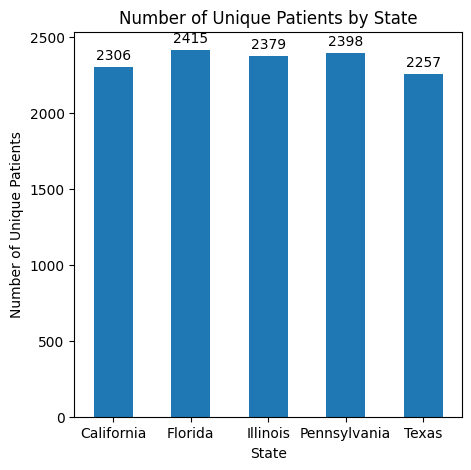

In [50]:
unique_patients_by_state = patients_all.groupby("STATE")["Id"].nunique()
#plot a bar chart
ax = unique_patients_by_state.plot(kind="bar", figsize=(5, 5))
# Customize the plot
plt.title("Number of Unique Patients by State")
plt.xlabel("State")
plt.ylabel("Number of Unique Patients")
plt.xticks(rotation=0)
for bar in ax.patches:
    height = bar.get_height()
    ax.annotate(f'{height}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')
plt.show()

In [55]:
states_order = ["Pennsylvania", "Illinois", "Florida", "Texas", "California", "Total"]
def categorical_summary(sub_df, var):
    counts = sub_df[var].value_counts(dropna=False)
    percents = sub_df[var].value_counts(normalize=True, dropna=False) * 100
    summary = counts.astype(str) + " (" + percents.round(1).astype(str) + "%)"
    return summary

def summarize_categorical(var):
    summaries = {}
    for state in ["Pennsylvania", "Illinois", "Florida", "Texas", "California"]:
        sub = patients_all[patients_all["STATE"] == state]
        summaries[state] = categorical_summary(sub, var)
    # Overall summary
    summaries["Total"] = categorical_summary(patients_all, var)

    df_summary = pd.DataFrame(summaries)
    df_summary = df_summary[states_order]
    return df_summary

def summarize_continuous(var):
    # List of stats to include
    stats = ["count", "mean", "median", "std", "min", "max"]
    summary_dict = {}
    for state in ["Pennsylvania", "Illinois", "Florida", "Texas", "California"]:
        sub = patients_all[patients_all["STATE"] == state]
        s = sub[var].describe()
        summary_dict[state] = [sub[var].count(), s["mean"], sub[var].median(), s["std"], s["min"], s["max"]]
    # Overall totals:
    #s_total = patients_all[var].describe()
    summary_dict["Total"] = [patients_all[var].count(), patients_all[var].mean(), patients_all[var].median(),
                             patients_all[var].std(), patients_all[var].min(), patients_all[var].max()]

    df_summary = pd.DataFrame(summary_dict, index=stats)
    df_summary = df_summary[states_order]
    return df_summary

def summarize_death():
    # For DEATHDATE, if there's a death date, count them as dead
    summary = {}
    for state in ["Pennsylvania", "Illinois", "Florida", "Texas", "California"]:
        sub = patients_all[patients_all["STATE"] == state]
        summary[state] = sub["DEATHDATE"].notnull().sum()
    summary["Total"] = patients_all["DEATHDATE"].notnull().sum()
    df_summary = pd.DataFrame(summary, index=["Dead Count"])
    df_summary = df_summary[states_order]
    return df_summary

#Print the tables
print("Marital Status Summary:")
summary_marital = summarize_categorical("MARITAL")
print(summary_marital, "\n")

print("Race Summary:")
summary_race = summarize_categorical("RACE")
print(summary_race, "\n")

print("Ethnicity Summary:")
summary_ethnicity = summarize_categorical("ETHNICITY")
print(summary_ethnicity, "\n")

print("Gender Summary:")
summary_gender = summarize_categorical("GENDER")
print(summary_gender, "\n")

print("Income Summary (Continuous Variable):")
summary_income = summarize_continuous("INCOME")
print(summary_income, "\n")

print("Death (Dead Count) Summary:")
summary_death = summarize_death()
print(summary_death, "\n")


Marital Status Summary:
         Pennsylvania     Illinois       Florida        Texas   California  \
MARITAL                                                                      
D         253 (10.6%)   236 (9.9%)   244 (10.1%)   204 (9.0%)   205 (8.9%)   
M        1010 (42.1%)  982 (41.3%)  1044 (43.2%)  851 (37.7%)  907 (39.3%)   
S         339 (14.1%)  313 (13.2%)   329 (13.6%)  281 (12.5%)  311 (13.5%)   
W           66 (2.8%)    68 (2.9%)     92 (3.8%)    70 (3.1%)    55 (2.4%)   
NaN       730 (30.4%)  780 (32.8%)   706 (29.2%)  851 (37.7%)  828 (35.9%)   

                Total  
MARITAL                
D         1142 (9.7%)  
M        4794 (40.8%)  
S        1573 (13.4%)  
W          351 (3.0%)  
NaN      3895 (33.1%)   

Race Summary:
          Pennsylvania      Illinois       Florida         Texas  \
RACE                                                               
asian        78 (3.3%)    115 (4.8%)     51 (2.1%)    102 (4.5%)   
black      278 (11.6%)   356 (15.0%)   40

Let's look at medications. What's most frequent?

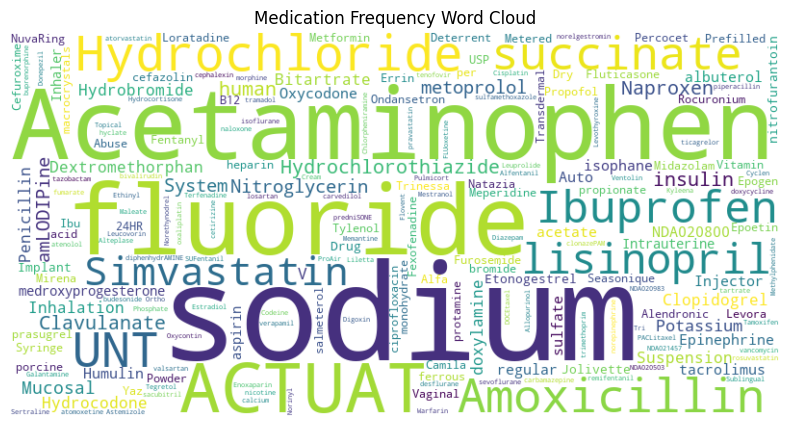

In [66]:
text = " ".join(medications["DESCRIPTION"].dropna().tolist())

# need to remove some text from the meds
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(["tablet", "capsule", "dose", "ML", "MG", "HR", "Oral", "Gel", "Day", "Injection", "Release", "Solution", "Extended", "Chewable", "Pack", "Injectable", "Spray"])

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white",
    stopwords=custom_stopwords,
    collocations=False
).generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Medication Frequency Word Cloud")
plt.show()

Response Variable count (2377 patients have a TRUE flagged. The rest will be set to False by Default)


In [71]:
cvd_table = pd.crosstab(index=conditions["cvd_flag"], columns="Count")
print(cvd_table)

col_0     Count
cvd_flag       
False      9378
True       2377


Check immunization frequencies

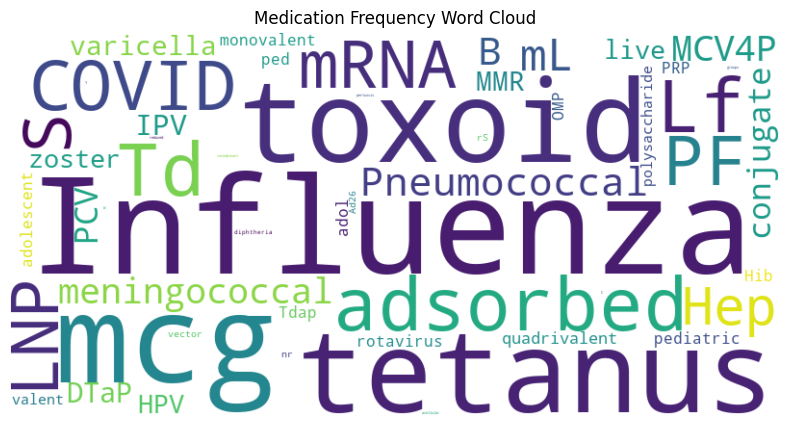

In [81]:
text = " ".join(immunizations["DESCRIPTION"].dropna().tolist())

# need to remove some text from the meds
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(["free", "preservative", "injectable","seasonal","adult", "dose", "absorbed", "vaccine", "5mL", "25mL"])

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white",
    stopwords=custom_stopwords,
    collocations=False
).generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Medication Frequency Word Cloud")
plt.show()

Let's look at allergies

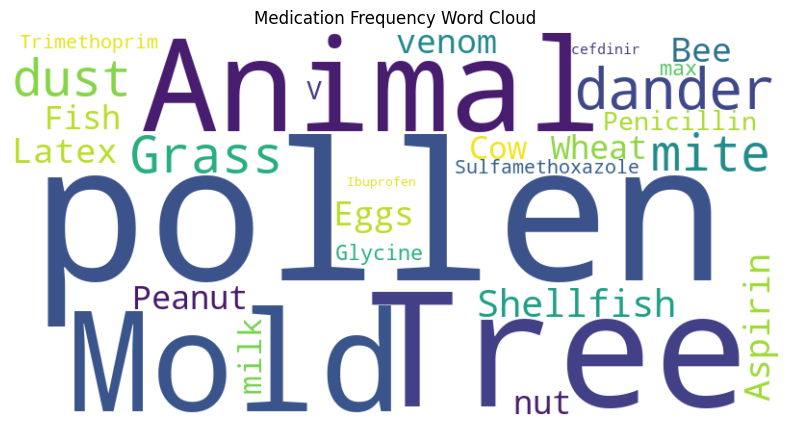

In [85]:
text = " ".join(allergies["DESCRIPTION"].dropna().tolist())

# need to remove some text from the meds
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(["House"])

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white",
    stopwords=custom_stopwords,
    collocations=False
).generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Medication Frequency Word Cloud")
plt.show()

Vitals

<Axes: xlabel='clean_desc', ylabel='clean_desc'>

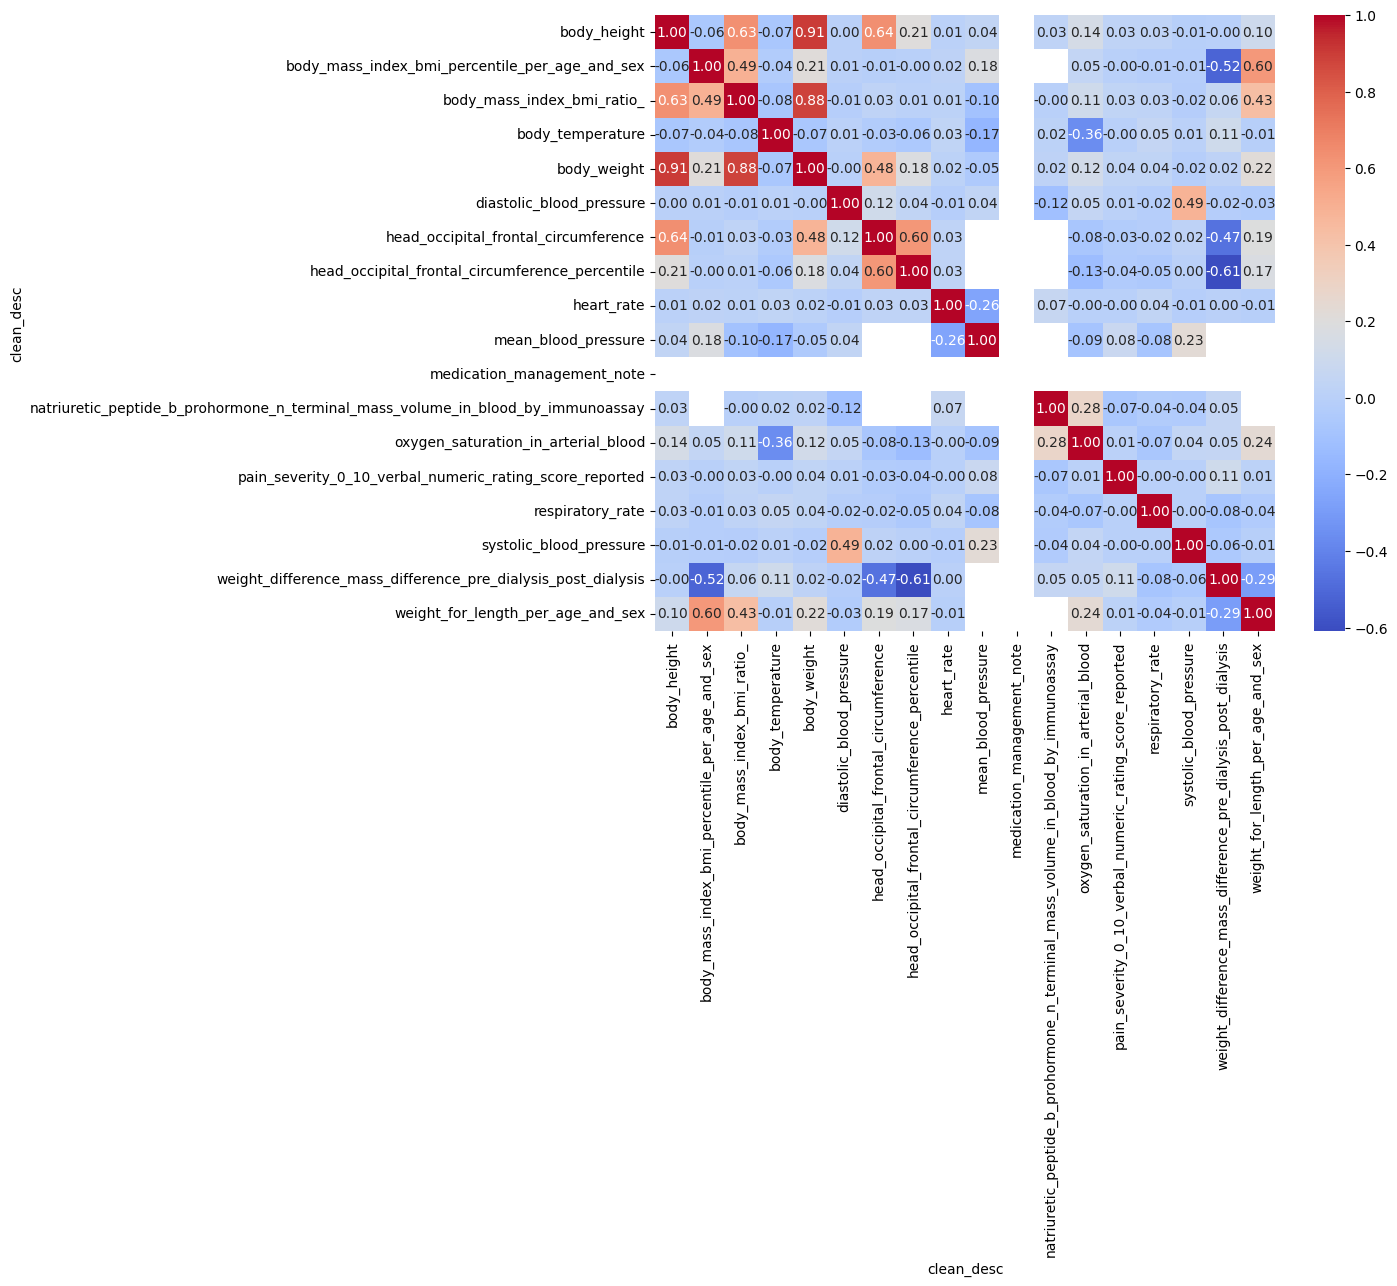

In [107]:
#clean what will become variables
observations["clean_desc"] = observations["DESCRIPTION"].astype(str).str.strip().str.lower().str.replace(r'\W+', '_', regex=True)

f_wide = observations.pivot_table(
    index="PATIENT",
    columns="clean_desc",
    values="VALUE",
    aggfunc='first'  # only 1 already but keeping it here
).reset_index()

#they need to be numeric
for col in f_wide.columns:
    if col != "PATIENT":
        f_wide[col] = pd.to_numeric(f_wide[col], errors='coerce')

#Compute the correlation matrix
numeric_df = f_wide.select_dtypes(include=[np.number])
numeric_df_corr_matrix = numeric_df.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
